## Lesson 06

Aluno: Sebastián Héctor Zuzunaga Rosado

Matricula: 211006957

## Objetivo

O objetivo é realizar uma predição de um AVC (Acidente Vascular Cerebral) numa pessoa usando diferentes dados sobre esta, para isso se utilizará o visto no capítulo 6 para criar árvores de decisão.

Primeiro serão realizados alguns Imports necessários, se procederá a ler a database e torná-la disponível para poder ser usada no notebook, também se definirão algumas coisas para serem usadas depois.

In [112]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [113]:
from pathlib import Path
import os
os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
path = Path('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
!pip install -Uqq fastai

In [114]:
df = pd.read_csv(path)

In [115]:
modes = df.mode().iloc[0]

In [116]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [117]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

## Data pre-processing

Agora se realizará o pré-processamento de dados, agora não será necessário criar variáveis dummy, se usar Pd. Categorical para transformar em variáveis categóricas, também se usará fillna devido a que existem alguns campos com NaN.

In [118]:
def proc_data(df):
    df['gender'] = pd.Categorical(df.gender)
    df['hypertension'] = pd.Categorical(df.hypertension)
    df['heart_disease'] = pd.Categorical(df.heart_disease)
    df['ever_married'] = pd.Categorical(df.ever_married)
    df['work_type'] = pd.Categorical(df.work_type)
    df['Residence_type'] = pd.Categorical(df.Residence_type)
    df['bmi'] = df.bmi.fillna(0)
    df.fillna(modes, inplace=True)
    df['smoking_status'] = pd.Categorical(df.smoking_status)

proc_data(df)

/tmp/ipykernel_32/2146538464.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(modes, inplace=True)


Aqui se definem que variáveis são contínuas, categóricas e qual é a variável dependente.

In [119]:
cats=["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status"]
conts=['age','avg_glucose_level', 'bmi']
dep="stroke"

In [120]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,0.0,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Binary splits

Binary splits são a base de como as árvores de decisão funcionam, para ilustrar aqui serão mostrados dois exemplos, porém primeiro vamos realizar o split da database em treinamento e validação.

In [121]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [122]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Agora se criarão funções para calcular a impureza dos splits para saber onde é melhor realizá-los.

In [123]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [124]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [125]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

In [126]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'gender': (1, 0.20534918589868767),
 'hypertension': (0, 0.19946650533416718),
 'heart_disease': (0, 0.19973040215297902),
 'ever_married': (0, 0.19891046760705028),
 'work_type': (3, 0.19803871145166815),
 'Residence_type': (0, 0.20513934395605082),
 'smoking_status': (0, 0.2037418357448045),
 'age': (47.0, 0.16631807402608773),
 'avg_glucose_level': (161.95, 0.19716504906423635),
 'bmi': (0.0, 0.19910776351050027)}

Você pode ver aqui que os dois melhores são idade e nível médio de glicose.

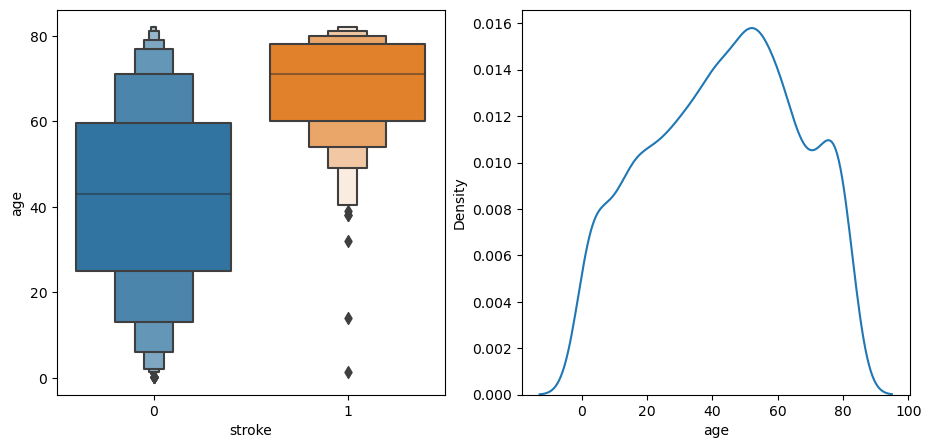

In [127]:
import seaborn as sns

df_fare = trn_df[trn_df.age>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="age", ax=axs[0])
sns.kdeplot(data=df_fare, x="age", ax=axs[1]);

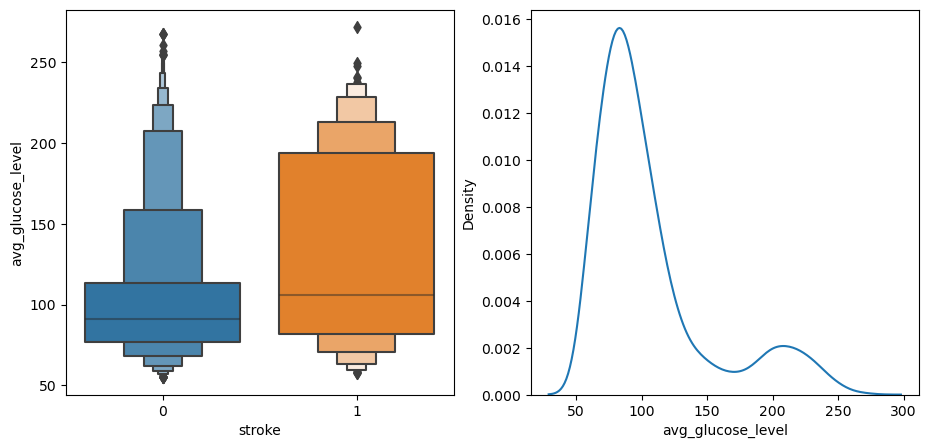

In [128]:
df_fare = trn_df[trn_df.avg_glucose_level>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="avg_glucose_level", ax=axs[0])
sns.kdeplot(data=df_fare, x="avg_glucose_level", ax=axs[1]);

Pode-se ver em ambos os casos, que no boxplot se mostra qual foi o valor médio para pessoas que sofreram um AVC e as que não sofreram, na direita se vê a densidade de dados para cada categoria.

## Creating a decision tree

Agora para criar a árvore de decisão você vai usar DecisionTreeClassifier, uma função de sklearn, em seguida, vamos fazer um feature importante para determinar qual o dado teve mais peso na árvore e você vai calcular o erro absoluto para identificar quão eficiente é a árvore.

In [129]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [130]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

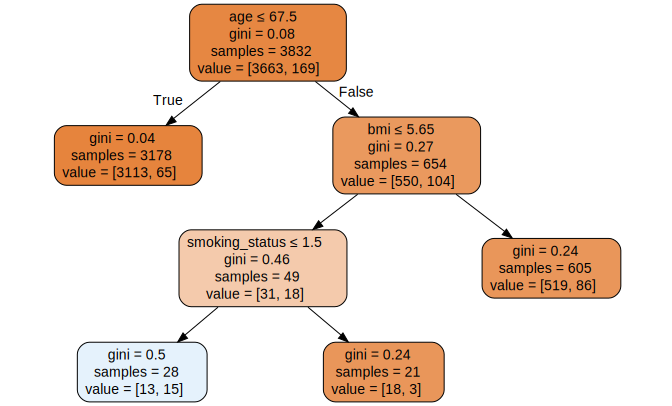

In [131]:
draw_tree(m, trn_xs, size=10)

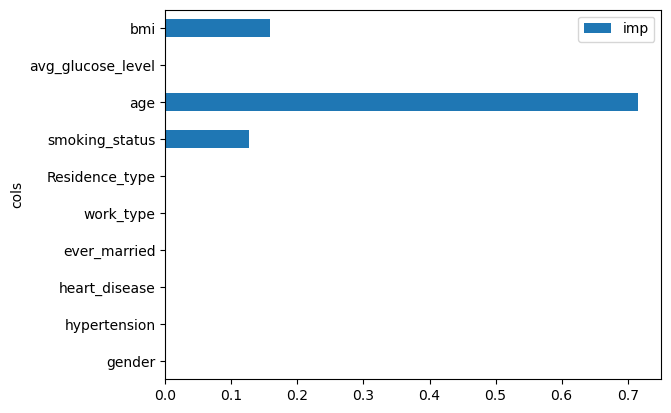

In [132]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [133]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, m.predict(val_xs))

0.061815336463223784

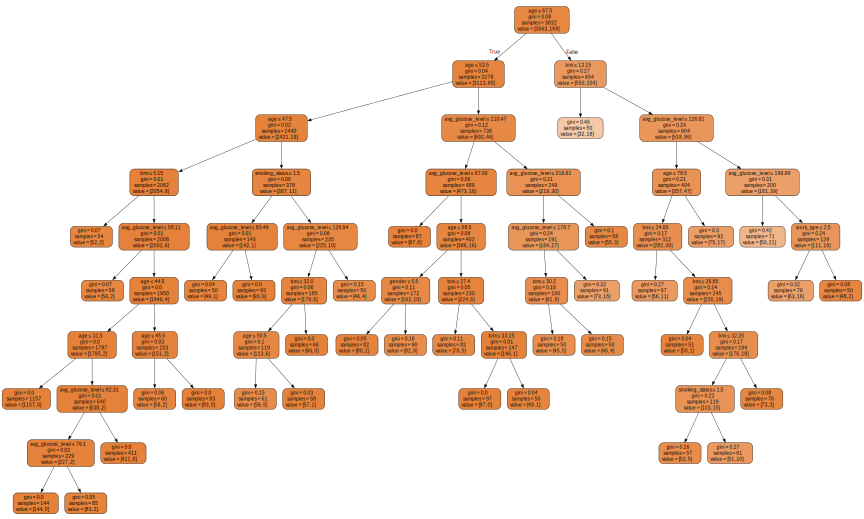

In [134]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

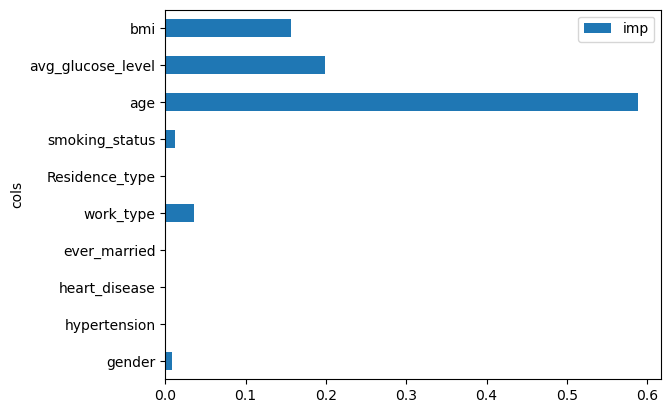

In [135]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [136]:
mean_absolute_error(val_y, m.predict(val_xs))

0.06259780907668232

## Random forest

O random forest é uma forma de melhorar as previsões feitas pela árvore de decisão, esta consiste em criar várias árvores muito grandes e tirar a média de suas previsões, Para garantir que estas não estejam correlacionadas, as diferentes árvores são treinadas com grupos de dados aleatórios.

In [137]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [138]:
trees = [get_tree() for t in range(100)]

In [139]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.07888106416275431

In [140]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.06259780907668232

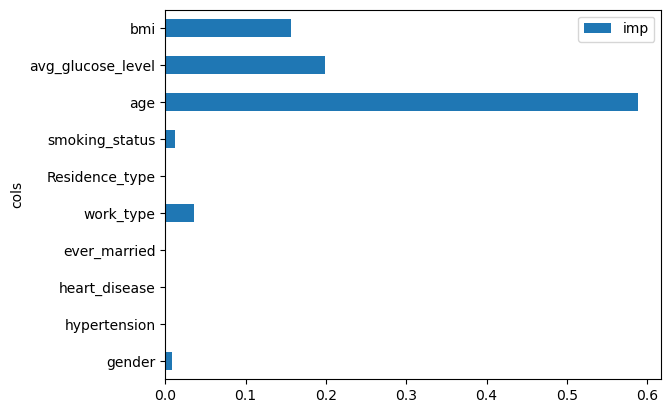

In [141]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

## Export Model

In [142]:
import joblib

In [143]:
filename = 'stroke_forest_model.pkl'
joblib.dump(rf, filename)

['stroke_forest_model.pkl']

## Deploy

https://huggingface.co/spaces/sebazac332/carspredict

## Conclusão

No final da lição se conclui que os modelos mais complexos nem sempre são superiores a uns mais simples, isto pode-se ver aqui sendo o random forest ligeiramente pior que a árvore de decisão, se tem agora um melhor entendimento de como funcionam as árvores de decisão e como certos dados afetam o resultado destas.